In [17]:
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import torch

In [28]:
# Import images from .npz files
# Extract data file paths
# file_path = r'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\HDF to npz files\\'
# Import images from .npz files
# Extract data file paths
file_path = "/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_sept_data/npz_field_sweep/"

# TEMP SWEEP MOVIES
# movies = ['121855.npz', '118923.npz', '119486.npz', '119996.npz', '120506.npz', '121016.npz', '121405.npz', '121550.npz', '122365.npz', '122875.npz']

# FIELD SWEEP MOVIES OLD
#movies = ['Field_29mT.npz', 'Field_31mT.npz', 'Field_32mT.npz', 'Field_33mT.npz', 'Field_37mT.npz']

#SEPT DATA
movies = ['neg23mT_553_50mW.npz', 'neg23mT_558_25mW.npz', 'neg25mT_553_50mW.npz', 'neg25mT_558_25mW.npz', 'neg27mT_553_50mW.npz', 
          'neg27mT_558_25mW.npz', 'neg29mT_553_50mW.npz', 'neg29mT_558_25mW.npz', 'neg31mT_553_50mW.npz', 'neg31mT_558_25mW.npz', 
          'neg33mT_553_50mW.npz', 'neg33mT_558_25mW.npz', 'neg35mT_553_50mW.npz', 'pos23mT_553_50mW.npz', 'pos23mT_558_25mW.npz', 
          'pos25mT_553_50mW.npz', 'pos25mT_558_25mW.npz', 'pos27mT_553_50mW.npz', 'pos27mT_558_25mW.npz', 'pos29mT_553_50mW.npz', 
          'pos29mT_558_25mW.npz', 'pos31mT_553_50mW.npz', 'pos31mT_558_25mW.npz', 'pos33mT_553_50mW.npz', 'pos33mT_558_25mW.npz']
# Define the movie you want to run GD and GS on as gif (gif = movies[i])
gif = movies[15]
print(gif)
movie = np.load(file_path + gif)
print(movie)
intensity_data = torch.tensor(movie['data'])
print(intensity_data.shape)


pos25mT_553_50mW.npz
NpzFile '/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_sept_data/npz_field_sweep/pos25mT_553_50mW.npz' with keys: data
torch.Size([299, 128, 128])


In [19]:
# Function 1: Define the mask function that divides the intensity grid into peaks (1) and noises (0)
def apply_threshold_mask(grid, threshold):
    masked_grid = np.where(grid < threshold, 0, 1)
    return masked_grid

In [20]:
# Function 2: Use recursive DFS to find all peaks (connected 1s) and return their coordinates
def get_peak_coordinates(grid):
    rows, cols = len(grid), len(grid[0])
    peaks = []

    def dfs(r, c, peak):
        """
        If out of bounds or is not a peak (0), return 0
        Mark the point as visited (change 1 to 0)
        Add the current point's coordinates to the current peak list
        Explore all 4 directions (up, down, left, right)
        """
        if r < 0 or r >= rows or c < 0 or c >= cols or grid[r][c] == 0:
            return 0
        grid[r][c] = 0
        peak.append((c, r)) # <=> (x, y)
        dfs(r + 1, c, peak)
        dfs(r - 1, c, peak)
        dfs(r, c + 1, peak)
        dfs(r, c - 1, peak)

    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == 1:
                current_peak = []
                dfs(r, c, current_peak)
                peaks.append(current_peak)
    
    return peaks

In [21]:
import math

# Function 3: Find azimuth width by finding the maximal Euclidean distance for each peak
def find_azimuth_width(points):
    max_dist = 0
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            x1, y1 = points[i]
            x2, y2 = points[j]
            distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            if distance > max_dist:
                max_dist = distance
    return max_dist

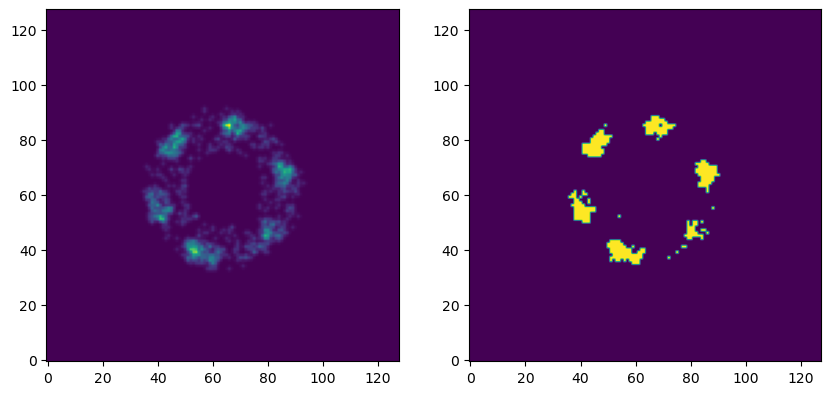

Peak coordinate list: [[(59, 35), (59, 36), (59, 37), (59, 38), (60, 38), (60, 37), (60, 36), (60, 35), (61, 35), (61, 36), (61, 37), (61, 38), (61, 39), (62, 39), (62, 40), (63, 40), (63, 39), (62, 38), (62, 37), (58, 38), (58, 39), (58, 40), (57, 40), (57, 39), (57, 38), (57, 37), (58, 37), (58, 36), (56, 37), (56, 38), (56, 39), (56, 40), (56, 41), (55, 41), (55, 42), (54, 42), (54, 43), (53, 43), (53, 42), (53, 41), (53, 40), (53, 39), (53, 38), (53, 37), (53, 36), (54, 36), (54, 37), (54, 38), (54, 39), (54, 40), (54, 41), (55, 40), (55, 39), (55, 38), (55, 37), (52, 37), (52, 38), (52, 39), (52, 40), (52, 41), (52, 42), (52, 43), (51, 43), (51, 42), (51, 41), (51, 40), (51, 39), (50, 41), (50, 42), (51, 37), (51, 36), (56, 36)], [(72, 37)], [(75, 39)], [(59, 41)], [(77, 41), (78, 41)], [(79, 44), (79, 45), (79, 46), (79, 47), (79, 48), (79, 49), (79, 50), (80, 48), (80, 47), (80, 46), (80, 45), (80, 44), (81, 45), (81, 46), (81, 47), (81, 48), (81, 49), (81, 50), (82, 50), (82, 4

In [33]:
# hyperparameter
cluster_threshold = 0.2

# Example (change the next line to see different frames)
intensity = intensity_data[5]
intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min())
processed_intensity = apply_threshold_mask(intensity, cluster_threshold)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(intensity / intensity.abs().max().detach().T, origin='lower')
ax[1].imshow(processed_intensity / processed_intensity.max().T, origin='lower')
plt.show()

peaks = get_peak_coordinates(processed_intensity)
widths = []
for i, points in enumerate(peaks):
    width = find_azimuth_width(points)
    widths.append(width)
print("Peak coordinate list:", peaks)
print("Azimuth width list:", widths)

In [23]:
# We can build a model that determines laser threshold from width/area once we're happy with the calculation above